In [9]:
import numpy as np
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
provider = IBMQ.load_account()
import warnings
warnings.filterwarnings('ignore')

ibmqfactory.load_account:WARNING:2023-11-09 14:41:11,635: Credentials are already in use. The existing account in the session will be replaced.


In [15]:
def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

def diffuser(n):
    qc = QuantumCircuit(n, name='Diff - "V"')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]),range(n))
    qc.h(range(n))
    return qc

def Grover(n, marked):
    qc = QuantumCircuit(n, n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    qc.h(range(n))
    for _ in range(r):
        qc.append(phase_oracle(n,marked),range(n))
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

5 qubits, basis state [15] marked, 4 rounds


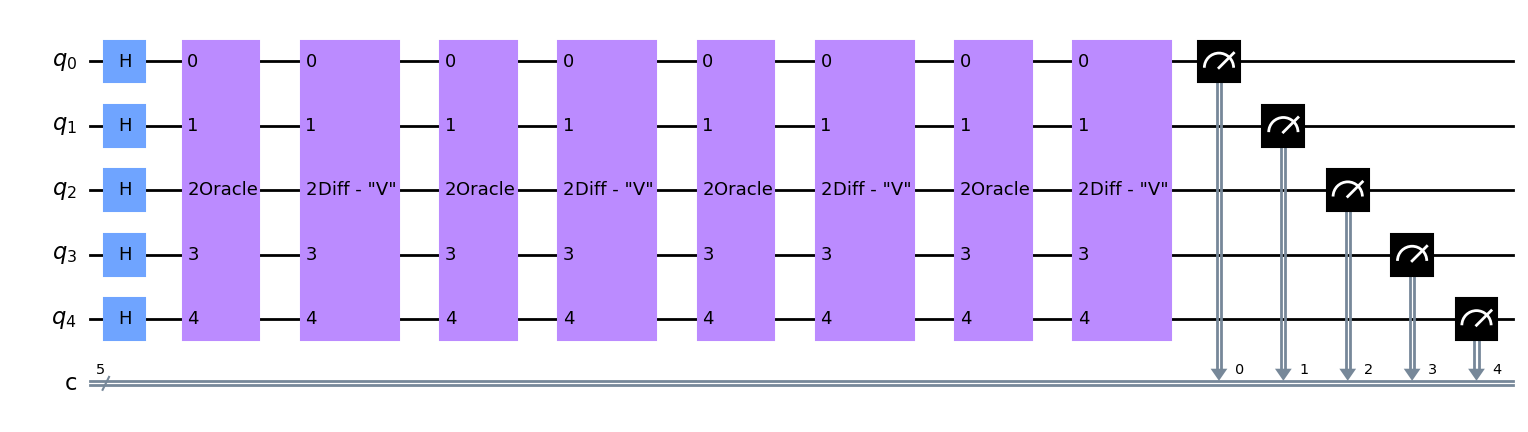

In [17]:
n = 5
x = np.random.randint(2**n)
marked = [x]
qc = Grover(n, marked)

qc.draw()

{'01010': 1, '10100': 1, '01000': 1, '10111': 1, '00000': 1, '01101': 1, '00100': 1, '10010': 1, '00001': 1, '10110': 1, '01111': 9990}
3.919534679768385


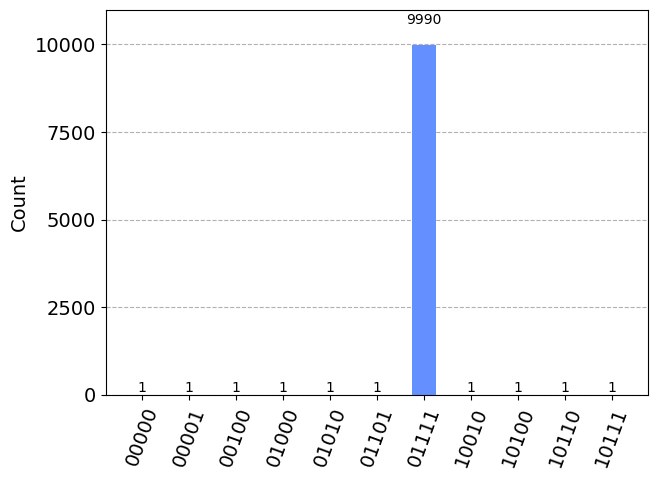

In [20]:
backend = Aer.get_backend('qasm_simulator')
result  = execute(qc, backend, shots = 10000).result()
counts = result.get_counts(qc)
print(counts)
print(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)
plot_histogram(counts)

5 qubits, basis state [15], 4 rounds


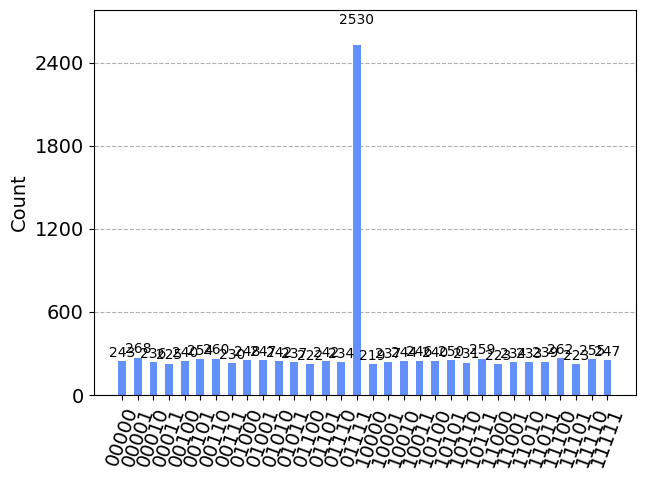

In [29]:
def Grover_run_roundwise(n, marked):
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked}, {r} rounds')
    counts = []
    for i in range(r):
        qc = QuantumCircuit(n, n)
        qc.h(range(n))
        for _ in range(i+1):
            qc.append(phase_oracle(n,marked), range(n))
            qc.append(diffuser(n), range(n))
        qc.measure(range(n),range(n))
        results = execute(qc, backend, shots=10000).result()
        counts.append(results.get_counts(qc))
    return counts

backend = Aer.get_backend('qasm_simulator')
counts = Grover_run_roundwise(n,marked)
plot_histogram(counts[0])

In [34]:
n = 3
x = np.random.randint(2**n)
y = np.random.randint(2**n)
while y == x :
    y = np.random.randint(2**n)
marked = [x,y]
qc = Grover(n,marked)

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                       not x.configuration().simulator and x.status().operational==True))

print("least busy backend: ", backend)
%qiskit_job_watcher

shots = 1024
job = execute(qc, backend=backend, shots = shots, optimization_level=3)
print(job.job_id())

3 qubits, basis state [1, 5] marked, 1 rounds
least busy backend:  ibm_nairobi


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

cn6gv7css5h00087jzhg


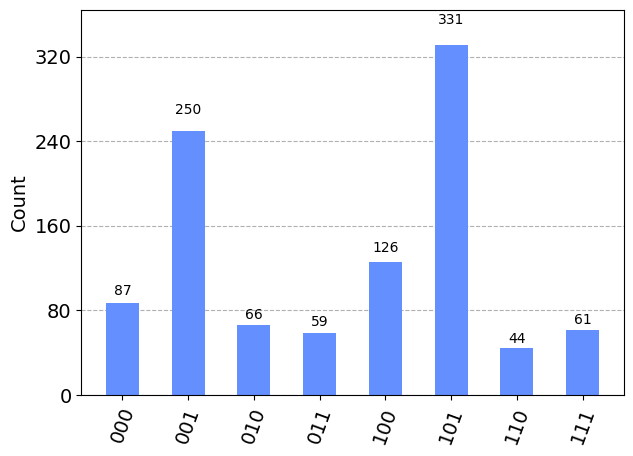

In [35]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()
plot_histogram(answer)